# Custom circuits:  quantization & spectra
With the `Circuit` class one can define and analyze custom circuits. The `Circuit` and `SymbolicCircuit` classes work hand in hand to **identify the periodic and extended degrees of freedom, and to eliminate the non-dynamical cyclic and frozen modes**. With this, the symbolic expression of the Hamiltonian is generated in terms of an appropriate choice of variables. 

The `Circuit` class also performs the **numerical diagonalization of the circuit Hamiltonian. Hierarchical diagonalization can be enabled for better runtime/memory perfomance.**

## Defining a custom circuit
Any superconducting circuit consists of **capacitances**, **inductances**, and **Josephson junctions**. 

<div class="alert alert-info">
    
Custom circuit definition
    
A custom circuit is specified via its graph consisting of nodes and branches. Start by labeling all circuit nodes with integer numbers n=1,2,3,... Every branch is a circuit element connecting two nodes.
    
For each branch:
   
- specify branch type: `JJ`, `L`, `C` for Josephson junction, inductance, and capacitance
- give the labels of two nodes connected by the branch
- provide circuit-element parameters (EJ and ECJ, EL, and EC, respectively)
</div>


As a concrete and familiar example, consider the circuit of the zero-pi qubit (nodes already labeled):
   
![zeropi](./zeropi-circ.jpg)

   
The graph of any custom circuit is stored in simple YAML format using the syntax illustrated here:

In [1]:
zp_yaml = """# zero-pi circuit
nodes: 4
branches:
- ["JJ", 1, 2, EJ = 10, 20]
- ["JJ", 3, 4, 10, 20]
- ["L", 2, 3, 0.008]
- ["L", 4, 1, 0.008]
- ["C", 1, 3, 0.02]
- ["C", 2, 4, 0.02]
"""

Alternatively, circuit specifications can be stored and loaded as `yaml` files with the same syntax. The graph description of the circuit is needed for creating an instance of the `Circuit` class. 


### More on syntax for entering custom circuits

The example above illustrates most of the syntax rules to be followed. Each branch is represented by 

```"<branch-type>", <node_1>, <node_2>, <param-1> [, <param-2>]```

**Branch types and parameters:**

- `C`:  branch parameter is the charging energy $E_C = \frac{e^2}{2C}$
- `L`:  branch parameter is the inductive energy $E_L = \frac{\Phi_0^2}{(2\pi)^2 L}$
- `JJ`: branch parameters are the Josephson energy $E_J$ and junction charging energy $E_{CJ}$

*Example:* `"C", 1, 3, 0.02` is a capacitance connecting nodes 1 and node 3, with charging energy 0.02 GHz.

**Symbolic vs. numerical branch branch parameters:**

- Branch parameters can be provided as float values, using the energy units set globally (default: GHz)
- A symbol name can be specified along with the value (e.g., `EJ = 10`). Where appropriate, symbolic expressions are given in terms of such provided symbol names.

    
**Ground node:**

A physical ground node (if to be included in the circuit), always has the label 0. It does not count towards the total number of nodes.

## Creating a `Circuit` object
Using the above string defining the zero-pi qubit, we can easily create a `Circuit` object:

In [2]:
import scqubits as scq
zero_pi = scq.Circuit.from_yaml(zp_yaml, from_file=False, ext_basis="discretized")

Here, `ext_basis` can be set to `"discretized"` or `"harmonic"`, and corresponds to the choice of using "spatial" discretization or decomposition in the harmonic oscillator basis for extended degrees of freedom.


This creation of a `Circuit` automatically runs methods for circuit analysis, quantization, and construction of the circuit Hamiltonian matrix. For instance, we can directly access the **symbolic expression of the circuit Hamiltonian**:

In [8]:
zero_pi.sym_hamiltonian()

-EJ*cos(1.0*θ1 - 1.0*θ3) + 0.01*Q2**2 + 40.0*Q3**2 + 0.04*n1**2 + 0.08*n1*ng_1 + 0.04*ng_1**2 + 0.032*θ2**2 + 0.008*θ3**2 - 10.0*cos(-Φ1 + 1.0*θ1 + 1.0*θ3)

All generalized coordinates are denoted by $\theta_i$; the conjugate charges are given by $Q_i$ for extended degrees of freedom, and by $n_i$ for periodic degrees of freedom.

.. note:
   The coordinates chosen here generally differ from the node variables. In their construction, periodic and extended 
   degrees of freedom are identified and separated. Furthermore, variable elimination is implemented for cyclic and 
   frozen degrees of freedom (if applicable).
   

The **symbolic Lagrangian in terms of node variables** can be accessed via 

In [4]:
zero_pi.sym_lagrangian()

EJ*cos(φ1 - φ2) + 0.5*\dot{φ_1}*(6.256*\dot{φ_1} - 0.006*\dot{φ_2} - 6.25*\dot{φ_3}) + 0.5*\dot{φ_2}*(-0.006*\dot{φ_1} + 6.256*\dot{φ_2} - 6.25*\dot{φ_4}) + 0.5*\dot{φ_3}*(-6.25*\dot{φ_1} + 6.256*\dot{φ_3} - 0.006*\dot{φ_4}) + 0.5*\dot{φ_4}*(-6.25*\dot{φ_2} - 0.006*\dot{φ_3} + 6.256*\dot{φ_4}) - 0.004*(φ1 - φ4)**2 - 0.004*(-φ2 + φ3)**2 + 10.0*cos(Φ1 - φ3 + φ4)

The equivalent expression of the **Lagrangian in terms of the transformed variables** used in `sym_hamiltonian` is:

In [9]:
zero_pi.sym_lagrangian(vars_type="new")

EJ*cos(1.0*θ1 - 1.0*θ3) + 6.256*\dot{θ_1}**2 + 25.0*\dot{θ_2}**2 + 0.006*\dot{θ_3}**2 - 0.032*θ2**2 - 0.008*θ3**2 + 10.0*cos(-Φ1 + 1.0*θ1 + 1.0*θ3)

The classification of the different variables is recorded in `var_categories`:

In [11]:
zero_pi.var_categories

{'periodic': [1], 'extended': [2, 3], 'cyclic': [], 'frozen': []}

The transformation matrix which maps the new variables ($\theta_i$) to node the variables ($\varphi_i$) can be inspected through `transformation_matrix`.

In [12]:
zero_pi.transformation_matrix

array([[ 0., -1.,  1.,  1.],
       [ 1., -1.,  0.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 0.,  1.,  0.,  1.]])

Each variable index comes with a **cutoff for basis truncation**. A list of the attribute names of these cutoffs can be accessed using:

In [14]:
zero_pi.cutoff_names

['cutoff_n_1', 'cutoff_ext_2', 'cutoff_ext_3']

We must next set these cutoffs to suitable values.

<div class="alert alert-warning">
    Convergence checks required
    
    Setting appropriate cutoff values and confirming convergence is the user's responsibility!
</div>

In [15]:
zero_pi.cutoff_n_1 = 5
zero_pi.cutoff_phi_2 = 10
zero_pi.cutoff_phi_3 = 10

Now, we can call `eigenvals()` to obtain **low-lying eigenenergies of the circuit Hamiltonian**: 

In [17]:
zero_pi.eigenvals()

array([-3.66713832, -3.65542458, -3.64979332, -3.63807958, -3.54945453,
       -3.54891778])

Increasing the above cutoff values reveals that these eigenvalues have not converged yet. Increasing cutoff values increases the Hilbert space dimension and, thus, increases memory requirements and runtime. A strategy that can help mitigate this problem is the use of hierarchical diagonalization.

## Hierarchical diagonalization
The expression from `sym_hamiltonian` shows that $\theta_2$ corresponds to the harmonic zeta mode of the zero-pi qubit. The remaining variables $\theta_1$ and $\theta_3$ form the primary qubit degrees of freedom and may be considered a "separate", weakly coupled subsystem. 

This idea of a **subsystem hierarchy is made explicit by grouping circuit variable indices in a nested list**:

In [21]:
system_hierarchy = [[1,3], [2]]

This nested list groups variables $1$ and $3$ into one subsystem, and makes variable $2$ a separate subsystem. 

List nesting extends to multiple layers, so that more complex hierarchies can be captured.  
For example, a zero-pi qubit coupled to an oscillator (variable $4$) could be associated with the hierarchy `[[[1,3], [2]], [4]]`.

For convenience, a default list of truncated Hilbert space dimensions is generated by `truncation_template`:

In [23]:
from scqubits.core.circuit import truncation_template
truncation_template(system_hierarchy)

[6, 6]

This default is meant to provide a list of the right shape whose entries should of course be adjusted. 

**To enable hierarchical diagonalization, the system hierarchy and truncation scheme info are handed over to** `set_system_hierarchy`:

In [24]:
zero_pi.set_system_hierarchy(system_hierarchy=system_hierarchy, subsystem_trunc_dims=[150, 80])

Once the hierarchy is set, subsystem Hamiltonians can be viewed via

In [25]:
zero_pi.sym_hamiltonian(subsystem_index=0)  # show Hamiltonian for subsystem 0

-EJ*sin(1.0*θ1)*sin(1.0*θ3) - EJ*cos(1.0*θ1)*cos(1.0*θ3) + 0.04*I**2*ng_1**2 + 0.08*I*n1*ng_1 + 40.0*Q3**2 + 0.04*n1**2 + 0.008*θ3**2 + 10.0*sin(1.0*θ1)*sin(1.0*θ3)*cos(6.283*I*Φ1) - 10.0*sin(1.0*θ1)*sin(6.283*I*Φ1)*cos(1.0*θ3) - 10.0*sin(1.0*θ3)*sin(6.283*I*Φ1)*cos(1.0*θ1) - 10.0*cos(1.0*θ1)*cos(1.0*θ3)*cos(6.283*I*Φ1)

Hamiltonian terms describing the coupling between two subsystems are displayed via

In [39]:
zero_pi.sym_interaction((0,1))  # show coupling terms between subsystems 0 and 1

0

(For the symmetric zero-pi qubit, the zeta mode and the primary qubit degrees of freedom decouple.)

Each subsystem has access to circuit methods, like `eigenvals`. Here are the unconverged (!) eigenenergies for the zeta mode:

In [42]:
zero_pi.subsystems[1].eigenvals()

array([0.02020856, 0.03755357, 0.13789236, 0.1384291 , 0.35421506,
       0.35421712])

Hierarchical diagonalization allows us to increase variable-specific cutoffs without exploding the dimension of the joint Hilbert space.

In [47]:
zero_pi.cutoff_n_1 = 10
zero_pi.cutoff_ext_2 = 100
zero_pi.cutoff_ext_3 = 80

zero_pi.subsystems[1].eigenvals()

array([0.01788547, 0.05363894, 0.08932603, 0.12486862, 0.16016157,
       0.1950773 ])

## External magnetic flux, offset charges

All external magnetic fluxes and offset charges can are set via attributes of the circuit class. A list of the corresponding attribute names is obtained via:

In [53]:
zero_pi.external_fluxes

[Φ1]

In [54]:
zero_pi.offset_charges

[ng_1]

In [ ]:
zero_pi.Φ1 = 0.5
zero_pi.ng_1 = 0.6

Now the eigenvalues and the parameter sweeps can be calculated like any other qubit in scqubits.

In [ ]:
eigs = zero_pi.eigenvals()
eigs - eigs[0]

In [ ]:
import numpy as np
zero_pi.plot_evals_vs_paramvals("Φ1", np.linspace(0,1,21))

## Visualization
### Plotting the potential
Potential of the circuit can also be plotted using the method `plot_potential`. To see how the potential expression looks like, we can call the attribute `potential_symbolic`.

In [55]:
zero_pi.potential_symbolic

-EJ*cos(1.0*θ1 - 1.0*θ3) + 0.016*(-θ2 + 0.5*θ3)**2 + 0.016*(θ2 + 0.5*θ3)**2 - 10.0*cos(-Φ1 + 1.0*θ1 + 1.0*θ3)

There are three degrees of freedoms in this potential for which ranges need to be specified. The variables like external flux can also be specified, else they are fetched from the Circuit attributes. Do note that only a maximum of two ranges can be specified as we can only plot in 3D. The method returns a line plot when only one range is specified.

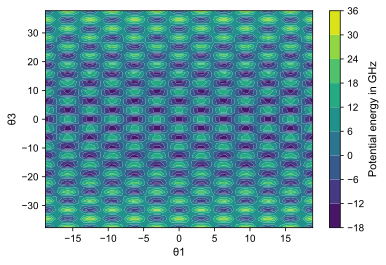

In [56]:
import numpy as np
zero_pi.plot_potential(θ1=np.linspace(-6*np.pi, 6*np.pi), θ3=np.linspace(-12*np.pi, 12*np.pi), θ2 = 0)

### Plotting the wavefunction
`plot_wavefunction` method is used to plot the wavefunction. It takes two arguments, which specify the choice of the wavefunction to be plotted and the variable indices along which it needs to be plotted. Again, a maximum of two variable indices can be requested to make a plot.

In [ ]:
zero_pi.plot_wavefunction(n=0, var_indices=(1,3))

## Extra features

In some cases, it might be possible that the transformation generated by the code is not what the user prefers. In such an instance the user can define a transformation and provide it as an input to the `initiate_circuit` method. The same applies to the external flux variables and to which branches they get associated to. The user can provide the list of branches to which external flux can be associated to (do note that any limit has not been implemented in the code to allow the user to associate external flux to more than one branch in a superconducting loop; though in this case the user must make sure the external flux assignment is consistent with what is expected from the circuit as the result might not be physical in some cases). In the case of zero-pi, for example, user can define custom transformation and closure branches as follows:

In [ ]:
import scqubits as scq
from scqubits.core.circuit import truncation_template
import numpy as np

zero_pi = scq.Circuit.from_yaml(input_string, is_file=False, ext_basis="harmonic", basis_completion="simple")

In [ ]:
zero_pi.sym_hamiltonian()

In [ ]:
zero_pi.branches

In [ ]:
closure_branches = [zero_pi.branches[3]]

trans_mat = np.array([[ -1,  -1,  1,  1],
                       [ 1,  1,  1,  1],
                       [ 1,  -1, -1,  1],
                       [ -1,  1,  -1,  1]])*0.5
system_hierarchy = [[1,2],[3]]
truncation_template(system_hierarchy)

In [ ]:
zero_pi.initiate_circuit(transformation_matrix=trans_mat, system_hierarchy=system_hierarchy, subsystem_trunc_dims=[50, 100], closure_branches=closure_branches)

In [ ]:
zero_pi.sym_hamiltonian()

In [ ]:
zero_pi.Φ1 = 0.0
zero_pi.ng_1 = 0.0

zero_pi.cutoff_n_1 = 6
zero_pi.cutoff_ext_2 = 80
zero_pi.cutoff_ext_3 = 100
eigs = zero_pi.eigenvals()
eigs - eigs[0]

## Tips: handling large circuits

- The method `from_yaml` also takes `basis_completion` as a parameter which can take two strings: `"simple"` and `"standard"`. These represent the two methods in which the identity matrix is generated to complete the transformation matrix to transform the node variables to new variables $\theta_i$. `"standard"` refers to an Identity, while `"simple"` refers to a matrix generated using itertools where each column has more than one non zero entries. Depending on the scenario, one of the above two options can result in a simpler Hamiltonian, resulting in a significant improvement in diagonalization time.